In [76]:
import numpy as np
import matplotlib.pyplot as plt
import ot

source = np.load('DataAssignment4/source.npy')
target = np.load('DataAssignment4/target.npy')

In [77]:
print(source.shape)
print(target.shape)

(157, 2)
(200, 2)


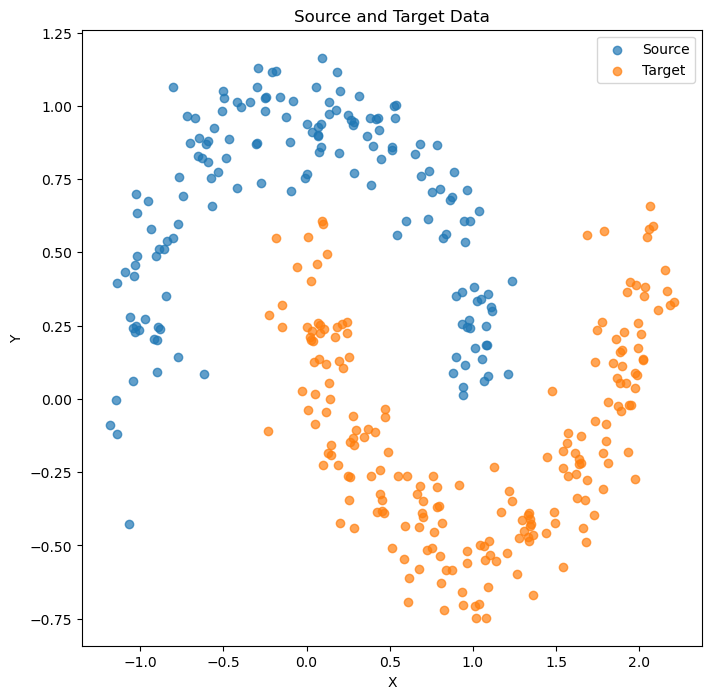

In [78]:
plt.figure(figsize=(8, 8))
plt.scatter(source[:, 0], source[:, 1], label='Source', alpha=0.7)
plt.scatter(target[:, 0], target[:, 1], label='Target', alpha=0.7)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Source and Target Data')
plt.show()

In [79]:
M = ot.dist(source, target, metric='euclidean') ** 2

# Uniform weights
a = np.ones(source.shape[0]) / source.shape[0]
b = np.ones(target.shape[0]) / target.shape[0]

# Sinkhorn algorithm
eps = 0.01  # regularization parameter
numItermax = 10000  # maximum number of iterations
stopThr = 1e-14  # stopping threshold, currently standard in OT
P, log = ot.sinkhorn(a, b, M,
                        eps,
                        numItermax=numItermax, 
                        stopThr=stopThr, 
                        verbose=False, 
                        warn=True, 
                        log=True)

cost = np.sum(P * M)
print("Transportation cost:", cost)


Transportation cost: 1.8077320632353455


In [80]:
print(log['err'][-1])

9.400000691988781e-15


In [81]:
#Epsilons no smaller than 0.01 because of numerical stability
epsilons = np.logspace(-2, 0, 10)
print("Epsilon grid overview:")
print("Shape:", epsilons.shape)
print("Values:", epsilons)
print("Min:", epsilons.min())
print("Max:", epsilons.max())
print("Step (logspace):", np.log10(epsilons[1]) - np.log10(epsilons[0]))

Epsilon grid overview:
Shape: (10,)
Values: [0.01       0.01668101 0.02782559 0.04641589 0.07742637 0.12915497
 0.21544347 0.35938137 0.59948425 1.        ]
Min: 0.01
Max: 1.0
Step (logspace): 0.22222222222222232


Best epsilon: 0.01
Best transportation cost: 1.8077320632353455


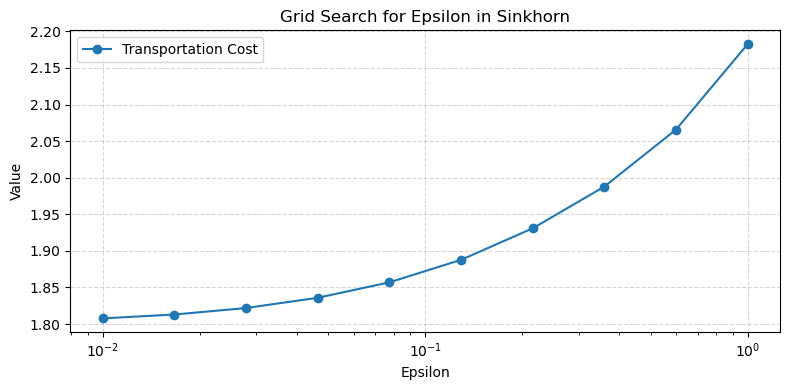

In [82]:
# Grid search for optimal epsilon in ot.sinkhorn
numItermax = 10000 
costs = []
errors = []

for eps_val in epsilons:
    P_tmp, log_tmp = ot.sinkhorn(a, b, M, eps_val, numItermax=numItermax, stopThr=stopThr, verbose=False, warn=True, log=True)
    cost_tmp = np.sum(P_tmp * M)
    costs.append(cost_tmp)
    errors.append(log_tmp['err'][-1])

best_idx = np.argmin(costs)
best_eps = epsilons[best_idx]
best_P, best_log = ot.sinkhorn(a, b, M, best_eps, numItermax=numItermax, stopThr=stopThr, verbose=False, warn=True, log=True)
print(f"Best epsilon: {best_eps}")
print(f"Best transportation cost: {costs[best_idx]}")

plt.figure(figsize=(8, 4))
plt.plot(epsilons, costs, marker='o', label='Transportation Cost')
plt.xscale('log')
plt.xlabel('Epsilon')
plt.ylabel('Value')
plt.title('Grid Search for Epsilon in Sinkhorn')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

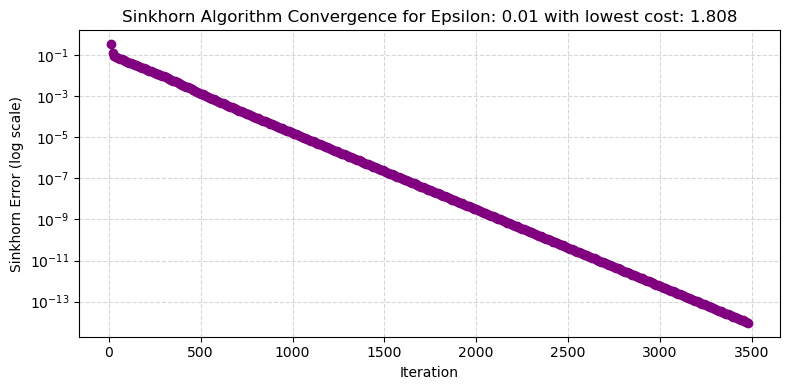

In [83]:
# Convergence criterion: plot the error curve from Sinkhorn log
plt.figure(figsize=(8, 4))
plt.plot(np.arange(10, 10 * (len(best_log['err']) + 1), 10), best_log['err'], marker='o', linestyle='-', color='purple')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Sinkhorn Error (log scale)')
plt.title(f'Sinkhorn Algorithm Convergence for Epsilon: {best_eps} with lowest cost: {round(costs[best_idx],3)}')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

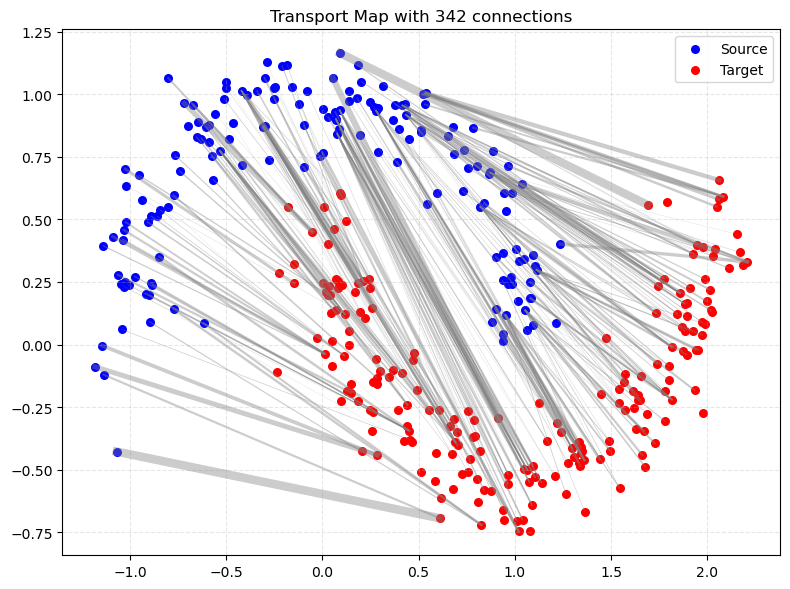

In [84]:
def plot_transport_map(source, target, P, max_lines=200, threshold=1e-4):
    """
    source: (n,2) array
    target: (m,2) array
    P: (n,m) transport plan from ot.sinkhorn
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(source[:,0], source[:,1], color='blue', label='Source', s=30)
    plt.scatter(target[:,0], target[:,1], color='red', label='Target', s=30)

    # Get non-zero entries in plan
    n, m = P.shape
    lines_plotted = 0
    for i in range(n):
        for j in range(m):
            if P[i, j] > threshold:
                plt.plot(
                    [source[i, 0], target[j, 0]],
                    [source[i, 1], target[j, 1]],
                    color='gray',
                    linewidth=10 * P[i, j] * n,  # scale line thickness
                    alpha=0.4
                )
                lines_plotted += 1
                if lines_plotted >= max_lines:
                    break

    plt.legend()
    plt.title(f'Transport Map with {lines_plotted} connections')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_transport_map(source, target, best_P)